In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import yaml

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

In [3]:
score_name = "perspective_score"

In [4]:
filepaths = yaml.load(open("/home/guilherme/Desktop/dissertation/config/filepaths.yaml"))

bins = np.linspace(0, 1, num=20)

/tmp/ipykernel_218872/3149349683.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  filepaths = yaml.load(open("/home/guilherme/Desktop/dissertation/config/filepaths.yaml"))


In [5]:
df_buckeye_data_desc = pd.read_csv(filepaths["00_buckeye_data_description"])

df_buckeye_data_desc = (
    df_buckeye_data_desc.rename(
        columns={
            "SPEAKER": "filename",
            "SPEAKER'S GENDER": "speaker"
        }
    )
)

df_buckeye_data_desc["speaker"] = (
    df_buckeye_data_desc
    .speaker.apply(
        lambda gender: "Man" 
        if gender=='m' 
        else "Woman"
    )
)
df_buckeye_data_desc["filename"] = df_buckeye_data_desc.filename.str.lower()
df_buckeye_data_desc["race"] = "White"
df_buckeye_data_desc["group"] = df_buckeye_data_desc["race"] + ' ' + df_buckeye_data_desc["speaker"]
df_buckeye_data_desc["filepath"] = filepaths["04_buckeye_scored"]

#### Build CORAAL's data description

In [6]:
filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(filepaths["04_coraal_scored"], "*"))]

data = []
for filename in filenames:
    description = {}
    
    description["filename"] = filename
    description["speaker"] = filename.split('_')[-3]
    description["race"] = "Black"
    
    data.append(description)
    
df_coraal_data_desc = pd.DataFrame(data)

In [7]:
df_coraal_data_desc["speaker"] = (
    df_coraal_data_desc
    .speaker.apply(
        lambda gender: "Man"
        if gender=='m'
        else "Woman"
    )
)

df_coraal_data_desc["group"] = df_coraal_data_desc["race"] + ' ' + df_coraal_data_desc["speaker"]
df_coraal_data_desc["filepath"] = filepaths["04_coraal_scored"]

In [8]:
df_data_desc = pd.concat([df_buckeye_data_desc, df_coraal_data_desc])

---

### Toxicity Score Cumulative Distribution Function (CDF)

Group: `Black Woman` had 0 reading problems
Group: `Black Man` had 0 reading problems
Group: `White Woman` had 0 reading problems
Group: `White Man` had 1 reading problems


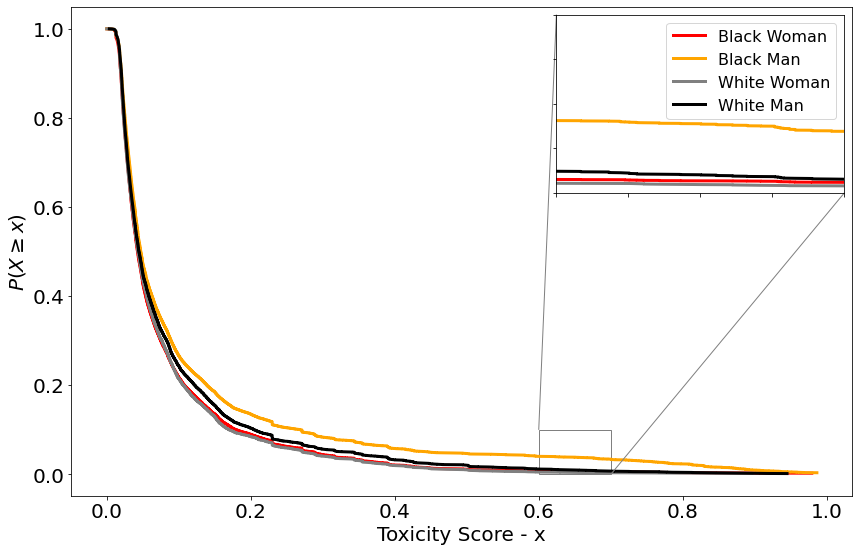

In [9]:
figure, ax = plt.subplots(figsize=(14,9))
axins = zoomed_inset_axes(ax, 4, loc=1)

group_color = {
    "Black Woman": "red",
    "Black Man": "orange",
    "White Woman": "grey",
    "White Man": "black"
}
for group in group_color.keys():
    df_group = df_data_desc[df_data_desc.group == group]
    
    dfs = []
    count = 0
    for path, filename in df_group[["filepath", "filename"]].values:
        try:
            df = pd.read_csv(os.path.join(path, filename))
            
#             df = df[~df.has_swearing]
            dfs.append(df)
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df = pd.concat(dfs)
    del dfs
    
    ecdf = ECDF(df[score_name])
    ax.plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])
    
    # Add a subaxis with the same traces
    axins.plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])

# The slice of the axis that will be zoomed in
axins.set_xlim(0.6, 0.7)
axins.set_ylim(0, 0.1)

plt.xticks(visible=False)
plt.yticks(visible=False)

# Draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.set_xlabel("Toxicity Score - x")
ax.set_ylabel(r"$P(X \geq x)$")

plt.legend()
plt.savefig(os.path.join(filepaths[f"buckeye_vs_coraal_imgs"], "inverse_cdf.pdf"))
plt.show()

---

### Toxicity Score Distribution

Group: `White Woman` had 0 reading problems
Group: `White Man` had 1 reading problems
Group: `Black Woman` had 0 reading problems
Group: `Black Man` had 0 reading problems


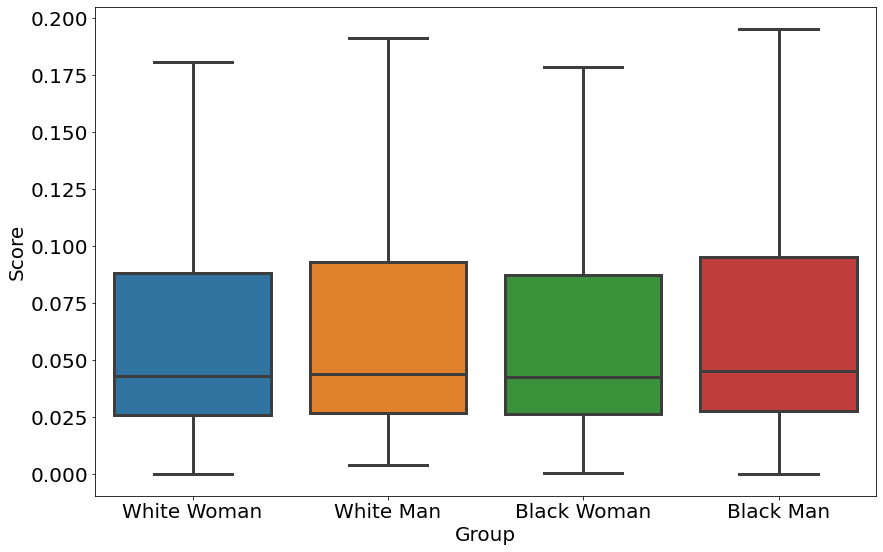

In [10]:
plt.subplots(figsize=(14,9))

dfs = []
for group in df_data_desc["group"].unique():
    df_group = []
    count = 0
    for path, filename in df_data_desc.loc[df_data_desc.group == group, ["filepath", "filename"]].values:
        try:
            df = pd.read_csv(os.path.join(path, filename))
            
            df = df[~df.has_swearing]
            df_group.append(df)
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df_group = pd.concat(df_group)
    df_group["group"] = group
    
    dfs.append(df_group)

df = pd.concat(dfs)
del dfs, df_group

sns.boxplot(data=df, x="group", y=score_name, showfliers=False)
plt.xlabel("Group")
plt.ylabel("Score")

plt.savefig(os.path.join(filepaths[f"buckeye_vs_coraal_imgs"], "group_distribution.pdf"))
plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [11]:
ks_all = []
groups = df.group.unique()
for first_group in groups:
    ks_one_vs_all = []
    for second_group in groups:
        statistic, p_value = ks_2samp(
            df[df.group == first_group][score_name],
            df[df.group == second_group][score_name]
        )
        
        ks_one_vs_all.append(
            f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
        )
    ks_all.append(ks_one_vs_all)

In [12]:
pd.DataFrame(ks_all, columns=groups, index=groups)

,White Woman,White Man,Black Woman,Black Man
White Woman,0.0 (100.0),2.534 (0.427),1.098 (32.523),4.17 (0.0)
White Man,2.534 (0.427),0.0 (100.0),2.48 (0.024),2.741 (0.004)
Black Woman,1.098 (32.523),2.48 (0.024),0.0 (100.0),3.916 (0.0)
Black Man,4.17 (0.0),2.741 (0.004),3.916 (0.0),0.0 (100.0)
